In this part, we will take a bit more time to explore the Wisconsin Breast Cancer dataset, described in
the class. 
Load the dataset using the file provided with this homework. 

Use ‘diagnosis’ as your target variable Y to be predicted (you can replace Malignant by 1, and Benign by 0, thus predicting cancer
malignancy). Make sure you remove ‘diagnosis’ and ‘id’ from the feature variables X.

Note that there are many types of model accuracy metrics, they all can be found in sklearn.metrics.



In [1]:
import sys
import os.path
import itertools

import pandas as pd
from sklearn import linear_model, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt
from typing import Callable, Union
%matplotlib inline

In [2]:
data = pd.read_excel("../Data/data.xlsx")

In [3]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [5]:
def create_labels(data):
    X = data.iloc[:,2:]
    # Using label binarizer to encode to binary (B=0; M=1)
    lbl = preprocessing.LabelBinarizer()
    y = lbl.fit_transform(data.iloc[:,1]) 
    return X,y

In [6]:
X, Y= create_labels(data)

Question 5: (5 pts)

Model A

Using LogisticRegression model and our greedy model selection algorithm that we have developed in
the previous homework (selecting the best F1, then second best F2, etc.), find the best 3-feature model.

Use sklearn.metrics.accuracy_score to select the model with the highest accuracy. Which one of the
features below appears in this model?

1. compactness_worst
2. fractal_dimension_se
3. smoothness_se
4. concave points_mean
5. perimeter_worst

Checkpoint: Model accuracy score should be close to 0.95606

In [7]:
class FeatureSelector:
    """ Class to contain feature selection algorithms
        To use this class, models should be defined
        as a function and return a dict containing:
        Error, Model and Params
    """

    def __init__(
        self, model: Callable, X: pd.DataFrame, y: pd.Series, minimum=True
    ) -> None:
        self.model = model
        self.X = X
        self.y = y
        self.minimum = minimum

    @staticmethod
    def best_model(results: list, _minimum=True) -> dict:
        """Returns `best` model from a list of model results
        Best is defined as the model with minimum error when _minimum is True
        otherwise, best is the maximum.
        """
        f = min if _minimum else max
        return f(results, key=lambda x: x["Error"])

    def best_subset(self, k: int) -> dict:
        "Returns best model of any k parameters"
        results = [
            self.model(self.X[list(params)], self.y)
            for params in itertools.combinations(self.X.columns, k)
        ]
        return FeatureSelector.best_model(results, _minimum=self.minimum)

    def best_n_subsets(self, n: int) -> list:
        "Returns a list of best subset models for each parameter size upto n"
        return [self.best_subset(k) for k in range(1, n + 1)]

    def _forward_selection(self, predictors: list) -> dict:
        "Inner loop of forward selection, find the next best predictor p"
        remaining_predictors = [p for p in self.X.columns if p not in predictors]
        results = [
            self.model(self.X[list(predictors) + [p]], self.y)
            for p in remaining_predictors
        ]
        return FeatureSelector.best_model(results, _minimum=self.minimum)

    def forward_selection(self, n: Union[bool, int] = None) -> list:
        "Find the best model of n parameters using forward selection"
        models, predictors = [], []
        n = n or len(self.X.columns)
        for _ in range(n):
            model = self._forward_selection(predictors)
            models.append(model)
            predictors = model.params
        return models

In [8]:
class Model:
    """Throwaway class to help reduce boiler plate
    Dict is returned to fit the interface of FeatureSelector
    """
    def __init__(self, model=None, metric=None, **kwargs):
        self._model = model
        self.metric = metric
        self.kwargs = kwargs

    def __call__(self, train_X, train_y, test_X=None, test_y=None):
        "Support separate train and test sets"
        test_X = train_X if test_X is None else test_X
        test_y = train_y if test_y is None else test_y
        m = self._model(**self.kwargs)
        m.fit(train_X, train_y)
        Y_hat = m.predict(test_X)
        error = self.metric(test_y, Y_hat)
        return {"Error":error, "Model":m, "Params": train_X.columns.values}


In [9]:
%%time

# Define a new logistic model with accuracy
log_acc = Model(model=linear_model.LogisticRegression, metric=accuracy_score)

# Find the best 3 feature subset with highest accuracy
model_best_acc = FeatureSelector(log_acc, X, Y, minimum=False).best_subset(k=3)

CPU times: user 36.7 s, sys: 652 ms, total: 37.4 s
Wall time: 41.3 s


In [10]:
print(f"Best accuracy model was: {model_best_acc['Error']} using features: {model_best_acc['Params']}")
assert round(model_best_acc['Error'],2) == .96

Best accuracy model was: 0.9578207381370826 using features: ['radius_mean' 'texture_mean' 'perimeter_worst']


Question 6: (5 pts)

Model B

Predicting cancer malignancy, one would definitely want to avoid false negatives: malignant cancer
cases erroneously classified by the model as benign.
Recall (or Sensitivity, https://en.wikipedia.org/wiki/Precision_and_recall) is another quality metric,
which determines how well a model can avoid false negatives. So let’s use the above greedy selection,
and change model selection metric from accuracy to recall (sklearn.metrics.recall_score).
Rerun the greedy code with this metric to select the 2-feature model with the highest recall.

How many features in this new model are the same as in the model A above?

1. None
2. One
3. Two
4. Three

Checkpoint: Model recall score should be close to 0.919811

Another interesting checkpoint – try running this algorithm to select the best 3-, 4-, 5-feature model, and
you will see, that the best recall value is not changing; and going higher will definitely result in an overfit.
So we have an interesting case when 2 features get all the job done.

In [11]:
%%time

# Define a new logistic model with recall
log_rec = Model(model=linear_model.LogisticRegression, metric=recall_score)
# Return model with highest recall
log_rec_r = FeatureSelector(log_rec, X, Y, minimum=False)
# Find the best 2 feature subset
model_best_recall = log_rec_r.best_subset(k=2)

print(f"Best recall model was: {model_best_recall['Error']} using features: {model_best_recall['Params']}")

Best recall model was: 0.9198113207547169 using features: ['texture_worst' 'perimeter_worst']
CPU times: user 3.47 s, sys: 66.1 ms, total: 3.54 s
Wall time: 3.93 s


In [12]:
assert round(model_best_recall["Error"],4) == .9198

Question 7: (6 pts)

Model C

Regression is great, but we want to find a very simple model any physician can use. So let’s consider
building a decision tree model. To develop something very interpretable that can be used by humans,
let’s also limit the number of decision tree leaves to 3 by using max_leaf_nodes parameter in
DecisionTreeClassifier().

As always, train the model on the entire dataset. Make a plot of the resulting model tree:

We have a patient with the following features

radius_worst&lt;12

radius_mean&gt;9

concave_points_worst&lt;0.1

Looking at this tree plot only, answer the following question:
What does this model tell us about the patient cancer classification?

1. Benign
2. Malignant
3. Equally probable to be Benign or Malignant

Checkpoint: Model accuracy score should be close to 0.94024


In [13]:
tree_model = Model(DecisionTreeClassifier, accuracy_score, max_leaf_nodes=3)
classifier = tree_model(X, Y)
print(f"Decision Tree accuracy: {classifier['Error']}")
assert round(classifier['Error'],4)==.9402

Decision Tree accuracy: 0.9402460456942003


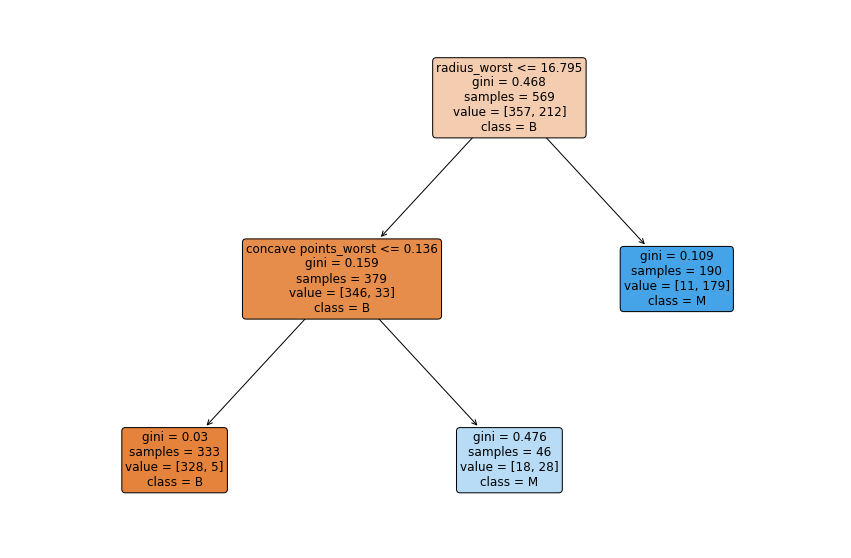

In [14]:
from sklearn import tree

fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(classifier["Model"],
    feature_names=list(X.columns),
    class_names=["B","M"],
    rounded = True,
    fontsize = 12,
    filled=True)

In [15]:
# for testing, lets just make sure that data with the supplied criteria returns the same label
test_data = data[(data["radius_worst"]<12) & (data["radius_mean"]>9) &(data["concave points_worst"]<.1)]
test_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
21,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.029560,0.020760,...,10.23,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
60,858970,B,10.170,14.88,64.55,311.9,0.11340,0.08061,0.010840,0.012900,...,11.02,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020
63,859196,B,9.173,13.86,59.20,260.9,0.07721,0.08751,0.059880,0.021800,...,10.01,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490
66,859464,B,9.465,21.01,60.11,269.4,0.10440,0.07773,0.021720,0.015040,...,10.41,31.56,67.03,330.7,0.15480,0.16640,0.09412,0.06517,0.2878,0.09211
97,862261,B,9.787,19.94,62.11,294.5,0.10240,0.05301,0.006829,0.007937,...,10.92,26.29,68.81,366.1,0.13160,0.09473,0.02049,0.02381,0.1934,0.08988


In [16]:
test_X, test_Y= create_labels(test_data)
assert all(test_Y==[0])

In [17]:
# Here we are training on the original data and testing on the subset data
# We should get a perfect match (accuracy=1) and the class should always predict "Benign"
dt_clf = Model(DecisionTreeClassifier, accuracy_score, max_leaf_nodes=3)
dt_m = dt_clf(X,Y,test_X, test_Y)
assert dt_m["Error"] == 1
assert all(test_Y==[0])

Question 8: (4 pts)

Model D

Now, let’s build a really small random forest, with only 10 trees, setting tree maximum depth to 3.

Compute the accuracy score of this forest (Model D) to the models A and C above. Which of the three
models produced the most accurate result?

1. A
2. C
3. D
4. All three models have the same accuracy

In [18]:
rf_clf = Model(RandomForestClassifier, accuracy_score, n_estimators=10, max_depth=3)
rf_m = rf_clf(X,Y)
print(f"Random forest accuracy: {rf_m['Error']}")

Random forest accuracy: 0.968365553602812
